# NLP: проект “Spam / Not Spam” (TF‑IDF + LogisticRegression)

**Цель урока:** за одно занятие пройти полный путь решения NLP‑задачи классификации текста:  
✅ загрузка данных → ✅ минимальный EDA → ✅ preprocessing → ✅ TF‑IDF → ✅ обучение модели → ✅ оценка → ✅ подбор порога → ✅ сохранение и тестирование модели.

**Датасет:** SMS Spam Collection (spam / ham)  
Источник: UCI ML Repository (id=228).

---

## Что вы поймёте после урока
1) Что такое NLP и почему “текст = числа”  
2) Как устроен **pipeline** решения текстовой задачи  
3) Что такое **TF‑IDF**
4) Как обучить **LogisticRegression** и оценить качество  
5) Как менять **порог**
6) Как сохранить модель и применять её к новым сообщениям

---


In [81]:
# Если запускаете на локальном ПК и чего-то нет — установите:
# !pip install pandas numpy scikit-learn matplotlib seaborn joblib ucimlrepo --quiet

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
)

import joblib

np.random.seed(42)
sns.set_style("whitegrid")

print("Ready ✅")

Ready ✅


# 1) Ввод: что такое NLP и как “машина понимает текст”

## NLP (Natural Language Processing)
Это область, где мы учим компьютер работать с человеческим языком:
- классификация текста (спам/не спам, токсичность, тема текста)
- поиск похожих текстов
- перевод
- суммаризация

---

## Маленькая история
- **1950-е**: вопрос “может ли машина думать?” (Тьюринг)
- **1980–2000-е**: статистические методы (частоты слов, n‑граммы)
- **2010-е**: мощный рост из‑за больших данных и GPU
- **сейчас**: нейросети, но **классические методы всё ещё полезны**

---

## Главная идея NLP
Компьютер не понимает буквы и слова.  
Он понимает **числа**.

Значит нам нужно сделать превращение:
**текст → признаки → модель**

Сегодня покажем самый популярный базовый способ:
✅ **TF‑IDF + LogisticRegression**


# 2) Пайплайн решения NLP‑задачи (шаблон для любого Kaggle)

Универсальный план действий:

1) **Загрузка датасета**
   - столбец с текстом
   - столбец с меткой класса (0/1)

2) **Мини‑EDA**
   - баланс классов (сколько спама?)
   - длина сообщений
   - примеры сообщений

3) **Preprocessing**
   - lower + убрать лишние символы
   - иногда: стоп‑слова, лемматизация

4) **Vectorization**
   - превращаем текст в числа
   - сегодня: **TF‑IDF**

5) **Train/Test split**

6) **Обучение модели** (LogisticRegression)

7) **Метрики**
   - accuracy, precision, recall, F1
   - confusion matrix

8) **Порог вероятности**
   - по умолчанию 0.5
   - но можно выбрать другой под задачу

9) **Сохранение модели**
   - сохраняем pipeline целиком
   - тестируем на новых текстах


# 3) Загрузка датасета “Спам / Не спам”

Варианты:
✅ через `ucimlrepo` (если есть интернет)  
✅ fallback: мини‑датасет (если нет интернета)


In [71]:
!pip install ucimlrepo

In [79]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
youtube_spam_collection = fetch_ucirepo(id=380)

print("X columns:", X_raw.columns.tolist())
print("y columns:", y_raw.columns.tolist())

print("X shape:", X_raw.shape)
print("y shape:", y_raw.shape)

X_raw = youtube_spam_collection.data.features
y_raw = youtube_spam_collection.data.targets

df = pd.concat([X_raw, y_raw], axis=1)

df = df.rename(columns={
    "AUTHOR": "author",
    "DATE": "date",
    "CONTENT": "text",
    "CLASS": "label"
})

print(df.shape)
df.head()

X columns: ['AUTHOR', 'DATE', 'CONTENT']
y columns: ['CLASS']
X shape: (1956, 3)
y shape: (1956, 1)
(1956, 4)


,author,date,text,label
0,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


# 4) Мини‑EDA

Смотрим:
- баланс классов
- длины сообщений


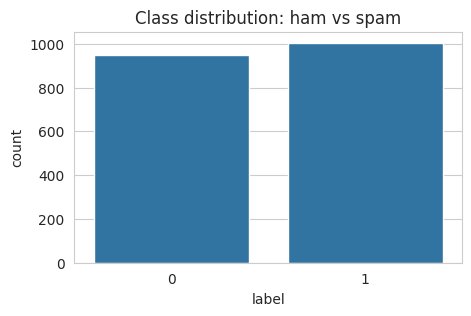

In [73]:
plt.figure(figsize=(5,3))
sns.countplot(x="label", data=df)
plt.title("Class distribution: ham vs spam")
plt.xlabel("label")
plt.ylabel("count")
plt.show()

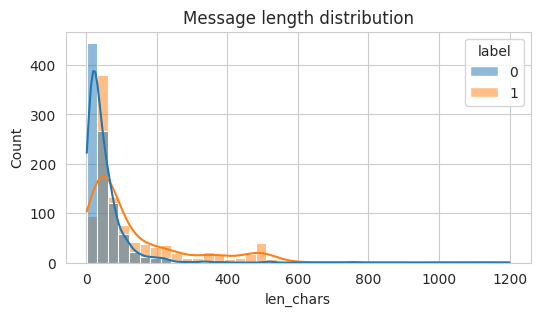

,label,text,len_chars
1360,0,Charlie from LOST?﻿,19
1703,0,BEST SONG EVER X3333333333﻿,27
1146,1,Aslamu Lykum... From Pakistan﻿,30
1758,1,I absolutely adore watching football plus I’ve...,487
374,1,I really love this video.. http://www.bubblews...,75


In [77]:
df["len_chars"] = df["text"].astype(str).apply(len)

plt.figure(figsize=(6,3))
sns.histplot(data=df, x="len_chars", hue="label", bins=40, kde=True)
plt.title("Message length distribution")
plt.xlabel("len_chars")
plt.show()

df[["label", "text", "len_chars"]].sample(5, random_state=42)

# 5) Preprocessing текста (минимально)

Базовая очистка:
- lower()
- убрать “не буквы/цифры/пробелы”
- убрать лишние пробелы


In [82]:
def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text_clean"] = df["text"].apply(clean_text)
df[["text","text_clean"]].head(5)

,text,text_clean
0,"Huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel kob...
1,Hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...
2,just for test I have to say murdev.com,just for test i have to say murdev com
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,me shaking my sexy ass on my channel enjoy
4,watch?v=vtaRGgvGtWQ Check this out .﻿,watch v vtarggvgtwq check this out


# 6) Train/Test split

`stratify=y` сохраняет долю классов в train и test.


In [83]:
X = df["text_clean"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("train size:", len(X_train))
print("test size :", len(X_test))
print("train spam rate:", float(y_train.mean()))
print("test spam rate :", float(y_test.mean()))

train size: 1564
test size : 392
train spam rate: 0.5140664961636828
test spam rate : 0.5127551020408163


# 7) TF‑IDF + LogisticRegression

TF‑IDF превращает текст в числа, а логистическая регрессия решает бинарную классификацию.


In [58]:
pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        max_features=8000,
        ngram_range=(1, 2)
    )),
    ("model", LogisticRegression(max_iter=2000)) # multi_class="multinomial", solver="lbfgs"
])

pipe

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=8000, ngram_range=(1, 2))),
                ('model', LogisticRegression(max_iter=2000))])

In [84]:
pipe.fit(X_train, y_train)

pred_test = pipe.predict(X_test)

acc = accuracy_score(y_test, pred_test)
prec = precision_score(y_test, pred_test, zero_division=0)
re = recall_score(y_test, pred_test, zero_division=0)
f1 = f1_score(y_test, pred_test, zero_division=0)

print("Test metrics:")
print("  accuracy :", round(acc, 4))
print("  precision:", round(prec, 4))
print("  recall   :", round(rec, 4))
print("  F1       :", round(f1, 4))

Test metrics:
  accuracy : 0.949
  precision: 0.9548
  recall   : 0.9453
  F1       : 0.95


In [85]:
tfidf = pipe.named_steps["tfidf"]
print('Vocabulary size:',
      len(tfidf.get_feature_names_out()))
print(tfidf.get_feature_names_out()[200:300])

Vocabulary size: 8000
['ago' 'ago and' 'agree' 'ahhh' 'album' 'alcoholic' 'alive' 'all'
 'all about' 'all around' 'all my' 'all of' 'all over' 'all the'
 'all these' 'all who' 'all you' 'all your' 'almost' 'almost billion'
 'alone' 'alot' 'already' 'already got' 'already have' 'also' 'also free'
 'also money' 'also wanna' 'always' 'always wanted' 'am' 'am am' 'am an'
 'am champion' 'am from' 'am just' 'am making' 'am new' 'am rapper'
 'am the' 'am video' 'am young' 'amazing' 'amazing love' 'amazing person'
 'amazing song' 'amazon' 'ambition' 'america' 'american' 'amount'
 'amount of' 'amp' 'amp campid' 'amp customid' 'amp hl' 'amp icep'
 'amp ipn' 'amp kw' 'amp kwid' 'amp may' 'amp mpt' 'amp mtid' 'amp pub'
 'amp set' 'amp share' 'amp subscribe' 'amp theater' 'amp toolid'
 'amp trksid' 'amp type' 'amp you' 'an' 'an african' 'an amazing'
 'an awesome' 'an hour' 'an iphone' 'an old' 'and' 'and 4000' 'and all'
 'and also' 'and am' 'and buy' 'and check' 'and coming' 'and drop'
 'and enjoy'

In [86]:
print("Classification report:\n")
print(classification_report(y_test, pred_test, digits=3))

Classification report:

              precision    recall  f1-score   support

           0      0.943     0.953     0.948       191
           1      0.955     0.945     0.950       201

    accuracy                          0.949       392
   macro avg      0.949     0.949     0.949       392
weighted avg      0.949     0.949     0.949       392



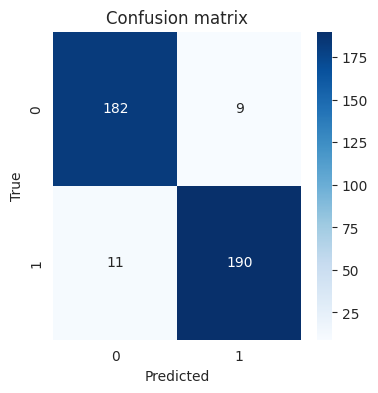

array([[182,   9],
       [ 11, 190]])

In [87]:
cm = confusion_matrix(y_test, pred_test)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

cm

# 8) Порог вероятности

`predict()` использует порог 0.5.  
Но можно менять порог и смотреть precision/recall.


In [88]:
proba_test = pipe.predict_proba(X_test)[:, 1]

def predict_with_threshold(proba, thr=0.5):
    return (proba >= thr).astype(int)

for thr in [0.3, 0.5, 0.7, 0.9]:
    pred_thr = predict_with_threshold(proba_test, thr)
    f1_thr = f1_score(y_test, pred_thr, zero_division=0)
    rec_thr = recall_score(y_test, pred_thr, zero_division=0)
    prec_thr = precision_score(y_test, pred_thr, zero_division=0)
    print(f"thr={thr:.1f} | precision={prec_thr:.3f} recall={rec_thr:.3f} f1={f1_thr:.3f}")

thr=0.3 | precision=0.773 recall=0.980 f1=0.864
thr=0.5 | precision=0.955 recall=0.945 f1=0.950
thr=0.7 | precision=0.988 recall=0.796 f1=0.882
thr=0.9 | precision=1.000 recall=0.393 f1=0.564


# 9) Какие слова “тянут” в спам?

Смотрим веса логистической регрессии.


In [89]:
tfidf = pipe.named_steps["tfidf"]
model = pipe.named_steps["model"]

feature_names = np.array(tfidf.get_feature_names_out())
coef = model.coef_.reshape(-1)

top_spam = np.argsort(coef)[-15:][::-1]
top_ham  = np.argsort(coef)[:15]

print("Top spam words/phrases:")
for idx in top_spam:
    print(f"{feature_names[idx]:<22} weight={coef[idx]:.3f}")

print("\nTop ham words/phrases:")
for idx in top_ham:
    print(f"{feature_names[idx]:<22} weight={coef[idx]:.3f}")

Top spam words/phrases:
com                    weight=4.023
subscribe              weight=3.847
out                    weight=3.649
check                  weight=3.515
check out              weight=3.394
please                 weight=2.839
http                   weight=2.587
www                    weight=2.366
channel                weight=2.291
my                     weight=2.247
https                  weight=2.071
and                    weight=1.839
my channel             weight=1.784
for                    weight=1.783
me                     weight=1.727

Top ham words/phrases:
song                   weight=-2.638
love                   weight=-2.156
views                  weight=-1.873
is                     weight=-1.851
shakira                weight=-1.525
this song              weight=-1.438
billion                weight=-1.424
best                   weight=-1.241
wow                    weight=-1.188
she                    weight=-1.178
good                   weight=-1.109
years

# 10) Сохранение и загрузка модели

Сохраняем pipeline целиком → потом используем на новых данных.


In [90]:
MODEL_PATH = "/spam_tfidf_logreg_pipeline.joblib"
joblib.dump(pipe, MODEL_PATH)
print("Saved:", MODEL_PATH)

Saved: /spam_tfidf_logreg_pipeline.joblib


In [91]:
pipe_loaded = joblib.load(MODEL_PATH)

test_messages = [
    "Congratulations! You've won a free ticket. Reply YES to claim.",
    "Hey, are we still meeting at 6 today?",
    "URGENT: call now to get your reward!!!",
    "I love your videos. Without you I'll be dead"
]

proba = pipe_loaded.predict_proba(test_messages)[:, 1]
pred  = (proba >= 0.5).astype(int)

pd.DataFrame({
    "text": test_messages,
    "spam_proba": proba.round(3),
    "pred(0=ham,1=spam)": pred
})

,text,spam_proba,"pred(0=ham,1=spam)"
0,Congratulations! You've won a free ticket. Rep...,0.539,1
1,"Hey, are we still meeting at 6 today?",0.360,0
2,URGENT: call now to get your reward!!!,0.553,1
3,I love your videos. Without you I'll be dead,0.479,0


---
# Итоги

✅ Полный проект сделан: загрузка → EDA → TF‑IDF → обучение → оценка → пороги → сохранение.


# 10 заданий на закрепление (код с пропусками)

Заполняйте `_____`.


## Задание 1

**Задание:** Сделайте столбец y: spam=1, ham=0.  
**Подсказка:** == 'spam'


In [ ]:
df["y"] = (df["label"].str.lower() == "_____").astype(int)
df[["label","y"]].head()

## Задание 2

**Задание:** Посчитайте долю спама.  
**Подсказка:** mean()


In [ ]:
spam_rate = df["_____"].mean()
print("spam rate:", round(spam_rate, 3))

## Задание 3

**Задание:** Добавьте длину сообщения.  
**Подсказка:** apply(len)


In [ ]:
df["len_chars"] = df["text"].astype(str).apply(_____)
df[["text","len_chars"]].head()

## Задание 4

**Задание:** Дописать clean_text.  
**Подсказка:** lower + re.sub


In [ ]:
import re
def clean_text(t):
    t = str(t)._____()
    t = re.sub(r"[^a-z0-9\s]", " ", _____)
    t = re.sub(r"\s+", " ", _____).strip()
    return t

print(clean_text("FREE!!! win $$$ now!!!"))

## Задание 5

**Задание:** Train/test split со stratify.  
**Подсказка:** train_test_split(..., stratify=y)


In [ ]:
from sklearn.model_selection import train_test_split
X = df["_____"]
y = df["_____"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=_____,
    random_state=_____,
    stratify=_____
)
print(len(X_train), len(X_test))

## Задание 6

**Задание:** Pipeline TF‑IDF + LogReg.  
**Подсказка:** Pipeline + TfidfVectorizer + LogisticRegression


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(max_features=_____, ngram_range=(_____, _____))),
    ("model", LogisticRegression(max_iter=_____))
])
pipe

## Задание 7

**Задание:** Обучите и посчитайте accuracy.  
**Подсказка:** fit + predict + accuracy_score


In [ ]:
from sklearn.metrics import accuracy_score
pipe._____(X_train, y_train)
pred = pipe._____(X_test)
acc = accuracy_score(y_test, pred)
print("accuracy:", round(acc, 4))

## Задание 8

**Задание:** Постройте confusion matrix heatmap.  
**Подсказка:** confusion_matrix + sns.heatmap


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(_____, _____)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

## Задание 9

**Задание:** Предсказания с порогом 0.7.  
**Подсказка:** predict_proba + thr


In [ ]:
from sklearn.metrics import f1_score

proba = pipe.predict_proba(X_test)[:, 1]
thr = _____
pred_thr = (proba >= thr).astype(int)

print("F1:", f1_score(y_test, pred_thr, zero_division=0))

## Задание 10

**Задание:** Сохраните и загрузите pipeline.  
**Подсказка:** joblib.dump + joblib.load


In [ ]:
import joblib
path = "/my_spam_model.joblib"

joblib._____(pipe, path)
pipe2 = joblib._____(path)

msg = ["Win free prize now!", "Let's meet tomorrow at 5"]
print(pipe2.predict(msg))